# Requirements :

In [ ]:
pip install holidays

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import RidgeCV
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.kernel_approximation import Nystroem

import time
from datetime import date, datetime
import holidays


# Reading Data :

In [6]:
train_data = pd.read_csv('/Users/mac/Desktop/Myrepo/Flights-Competition/data/flights_train.csv.bz2')
train_data.head()

,flight_date,from,to,avg_weeks,target,std_weeks
0,2012-06-19,ORD,DFW,12.875000,12.331296,9.812647
1,2012-09-10,LAS,DEN,14.285714,10.775182,9.466734
2,2012-10-05,DEN,LAX,10.863636,11.083177,9.035883
3,2011-10-09,ATL,ORD,11.480000,11.169268,7.990202
4,2012-02-21,DEN,SFO,11.450000,11.269364,9.517159


In [12]:
target_name = "target"
target = train_data['target']
data_train = train_data.drop(columns=[target_name])
data_train.head()

,flight_date,from,to,avg_weeks,std_weeks
0,2012-06-19,ORD,DFW,12.875000,9.812647
1,2012-09-10,LAS,DEN,14.285714,9.466734
2,2012-10-05,DEN,LAX,10.863636,9.035883
3,2011-10-09,ATL,ORD,11.480000,7.990202
4,2012-02-21,DEN,SFO,11.450000,9.517159


In [13]:
test_data = pd.read_csv('/Users/mac/Desktop/Myrepo/Flights-Competition/data/flights_Xtest.csv.bz2')
test_data.head()

,flight_date,from,to,avg_weeks,std_weeks
0,2013-01-22,ATL,MCO,10.363636,8.232025
1,2013-02-22,ATL,DEN,8.294118,5.542616
2,2013-01-31,ORD,EWR,8.933333,9.407191
3,2012-11-15,DFW,ORD,9.900000,6.608607
4,2013-02-13,SEA,SFO,7.000000,4.472136


In [14]:
numerical_columns = [c for c in data_train.columns
                     if data_train[c].dtype.kind in ["i", "f"]]
data_numeric = data_train[numerical_columns]

# Only Numerical Data :

In [15]:
data_train, data_test, target_train, target_test = train_test_split(
    data_numeric, target, test_size=  0.25, random_state=42
)

print(
    f"The training dataset contains {data_train.shape[0]} samples and "
    f"{data_train.shape[1]} features"
)
print(
    f"The testing dataset contains {data_test.shape[0]} samples and "
    f"{data_test.shape[1]} features"
)

The training dataset contains 6672 samples and 2 features
The testing dataset contains 2224 samples and 2 features


In [16]:
# Models params :


xgb_params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
}

Rf_params = {
    "n_estimators": 500,
    "max_depth": 2,
}

start = time.time()
Xbg_model = ensemble.GradientBoostingRegressor(**xgb_params)
Xbg_model.fit(data_train, target_train)
elapsed_time_1 = time.time() - start

start = time.time()
Rf_model = ensemble.RandomForestRegressor(**Rf_params)
Rf_model.fit(data_train, target_train)
elapsed_time_2 = time.time() - start

print(
    f"The model {Xbg_model.__class__.__name__} was trained in "
    f"{elapsed_time_1:.3f} seconds"
)
print()
print(
    f"The model {Rf_model.__class__.__name__} was trained in "
    f"{elapsed_time_2:.3f} seconds"
)

The model GradientBoostingRegressor was trained in 3.593 seconds

The model RandomForestRegressor was trained in 1.520 seconds


In [18]:
param_grid = {'max_depth': [3, 5, 10],
               'min_samples_split': [2, 5, 10]
}


base_estimator = ensemble.RandomForestRegressor(random_state=0)

sh = HalvingGridSearchCV(base_estimator, param_grid, cv=5,
                         factor=2, resource='n_estimators',
                         max_resources=30).fit(data_train, target_train)
sh.best_estimator_

RandomForestRegressor(max_depth=3, n_estimators=24, random_state=0)

In [19]:
best_Rf_model = ensemble.RandomForestRegressor(max_depth=3, n_estimators=24, random_state=0)
best_Rf_model.fit(data_train, target_train)


RandomForestRegressor(max_depth=3, n_estimators=24, random_state=0)

In [20]:
mse_3 = mean_squared_error(target_test, best_Rf_model.predict(data_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse_3))

The mean squared error (MSE) on test set: 0.8746


Even with tuning of the parameters the RF model still not improving.

# Inclding categorical data :

This part was inspired from : https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#sphx-glr-auto-examples-applications-plot-cyclical-feature-engineering-py

In [21]:
# Format flight_date to datetime :

train_data['flight_date'] = train_data['flight_date'].astype('datetime64')
train_data['flight_date'].dtype

dtype('<M8[ns]')

In [22]:
# Add a year column :

train_data['flight_year']= [ x.year for x in train_data['flight_date']]
train_data['flight_year'].unique()

array([2012, 2011])

In [23]:
# Make "2011" as year reference :

train_data['flight_year'] = train_data['flight_year'] - 2011

In [24]:
# Add a month column : 

train_data['flight_month']= [ x.month for x in train_data['flight_date']]

In [25]:
# Add a weekday column and weekend binary variable :

L = []
L_days = []

for x in train_data['flight_date'] :
    d = x.weekday() 
    L_days.append(d)
    
    if d > 4 :
        L.append(1)
    else : 
        L.append(0)

train_data['week_day'] = L_days
train_data['weekend'] = L


In [27]:
# Add a holiday variable :

us_holidays = holidays.US()

train_data['holiday'] = [x in us_holidays for x in train_data['flight_date']]

In [28]:
# Drop flight_date variable :

new_data = train_data.drop('flight_date', axis=1)

### All in one : (date processing)

In [29]:
def date_processing(dataset):
    #Format
    dataset['flight_date'] = dataset['flight_date'].astype('datetime64')
    #Add year column 
    dataset['flight_year']= [ x.year for x in dataset['flight_date']]
    #Add month column
    dataset['flight_month']= [ x.month for x in dataset['flight_date']]
    #Add work_day and weekend features 
    L = []
    L_days = []

    for x in dataset['flight_date'] :
        d = x.weekday() 
        L_days.append(d)
        
        if d > 4 :
            L.append(1)
        else : 
            L.append(0)

    dataset['week_day'] = L_days
    dataset['weekend'] = L
    #Add holiday variable 
    us_holidays = holidays.US()
    dataset['holiday'] = [x in us_holidays for x in dataset['flight_date']]

    return dataset.drop('flight_date', axis=1)

In [30]:
new_data = date_processing(train_data)
new_data

,from,to,avg_weeks,target,std_weeks,flight_year,flight_month,week_day,weekend,holiday
0,ORD,DFW,12.875000,12.331296,9.812647,2012,6,1,0,False
1,LAS,DEN,14.285714,10.775182,9.466734,2012,9,0,0,False
2,DEN,LAX,10.863636,11.083177,9.035883,2012,10,4,0,False
3,ATL,ORD,11.480000,11.169268,7.990202,2011,10,6,1,False
4,DEN,SFO,11.450000,11.269364,9.517159,2012,2,1,0,False
...,...,...,...,...,...,...,...,...,...,...
8891,DEN,PHX,11.045455,9.795363,7.791798,2011,11,3,0,True
8892,ATL,DEN,11.000000,9.429776,7.937254,2012,9,5,1,False
8893,ORD,EWR,9.476190,12.029971,6.903760,2012,8,4,0,False
8894,ORD,IAH,10.250000,9.381645,7.107261,2012,7,1,0,False


In [31]:
new_data['from'].unique()

array(['ORD', 'LAS', 'DEN', 'ATL', 'SFO', 'EWR', 'IAH', 'LAX', 'JFK',
       'PHL', 'SEA', 'MIA', 'BOS', 'DFW', 'MSP', 'CLT', 'MCO', 'PHX',
       'DTW', 'LGA'], dtype=object)

In [32]:
new_data['to'].unique()

array(['DFW', 'DEN', 'LAX', 'ORD', 'SFO', 'LAS', 'CLT', 'MSP', 'PHX',
       'MCO', 'DTW', 'MIA', 'BOS', 'PHL', 'JFK', 'EWR', 'ATL', 'LGA',
       'SEA', 'IAH'], dtype=object)

In [33]:
X = new_data.drop("target", axis=1)
y = new_data['target']

In [34]:
# Prepare for a Time series CV :


ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=48,
    max_train_size=7800,
    test_size=1000,
)

In [35]:
all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[0]

In [36]:
X.iloc[test_0]

,from,to,avg_weeks,std_weeks,flight_year,flight_month,week_day,weekend,holiday
3896,LGA,BOS,8.812500,8.463402,2012,9,1,0,False
3897,ORD,DFW,10.700000,7.692101,2012,1,0,0,False
3898,LAX,LAS,18.666667,12.196018,2012,10,2,0,False
3899,DEN,LAS,12.208333,8.890538,2011,12,5,1,False
3900,BOS,LAX,12.923077,8.332697,2011,9,6,1,False
...,...,...,...,...,...,...,...,...,...
4891,BOS,ORD,8.611111,5.542763,2012,4,4,0,False
4892,EWR,MCO,16.032258,10.264774,2011,10,5,1,False
4893,SFO,EWR,12.909091,10.618533,2012,1,0,0,False
4894,DTW,ORD,9.631579,6.775860,2012,1,3,0,False


In [37]:
# Encoding of the  categorical Data :


categorical_columns = [
    "from",
    "to",
    "holiday",
]
categories = [
    ['ORD', 'LAS', 'DEN', 'ATL', 'SFO', 'EWR', 'IAH', 'LAX', 'JFK',
       'PHL', 'SEA', 'MIA', 'BOS', 'DFW', 'MSP', 'CLT', 'MCO', 'PHX',
       'DTW', 'LGA'],
    ['DFW', 'DEN', 'LAX', 'ORD', 'SFO', 'LAS', 'CLT', 'MSP', 'PHX',
       'MCO', 'DTW', 'MIA', 'BOS', 'PHL', 'JFK', 'EWR', 'ATL', 'LGA',
       'SEA', 'IAH'],
    ["False", "True"],
]
ordinal_encoder = OrdinalEncoder(categories=categories)

In [38]:
# Evalluation function :

def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )


### Ridge Model :

In [86]:
one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
alphas = np.logspace(-6, 6, 25)

# Model Pipelline : 
naive_linear_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", one_hot_encoder, categorical_columns),
        ],
        remainder=MinMaxScaler(),
    ),
    RidgeCV(alphas=alphas),
)


evaluate(naive_linear_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.552 +/- 0.014
Root Mean Squared Error: 0.710 +/- 0.026


### Histogram-based Gradient Boosting :

In [41]:
# Model Pipelline : 

gbrt_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", one_hot_encoder, categorical_columns),
        ],
        remainder=MinMaxScaler(),
    ),
    HistGradientBoostingRegressor(
        categorical_features=range(3),
    ),
)


evaluate(gbrt_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.336 +/- 0.014
Root Mean Squared Error: 0.464 +/- 0.023


In [87]:
# Model Pipelline : 

adaboost_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", one_hot_encoder, categorical_columns),
        ],
        remainder=MinMaxScaler(),
    ),
    AdaBoostRegressor(),
)


evaluate(adaboost_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.622 +/- 0.012
Root Mean Squared Error: 0.791 +/- 0.021


## With Sin & Cos transformations :

In [43]:
# Define transformations :

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [44]:
cyclic_cossin_transformer = ColumnTransformer(
    transformers=[
        ("categorical", one_hot_encoder, categorical_columns),
        ("month_sin", sin_transformer(12), ["flight_month"]),
        ("month_cos", cos_transformer(12), ["flight_month"]),
        ("weekday_sin", sin_transformer(7), ["week_day"]),
        ("weekday_cos", cos_transformer(7), ["week_day"]),
    ],
    remainder=MinMaxScaler(),
)
cyclic_cossin_linear_pipeline = make_pipeline(
    cyclic_cossin_transformer,
    RidgeCV(alphas=alphas),
)
evaluate(cyclic_cossin_linear_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.546 +/- 0.016
Root Mean Squared Error: 0.703 +/- 0.027


In [45]:
hgb_cossin_pipeline = make_pipeline(
    cyclic_cossin_transformer,
    HistGradientBoostingRegressor(
        categorical_features=range(3),
    ),
)
evaluate(hgb_cossin_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.332 +/- 0.014
Root Mean Squared Error: 0.458 +/- 0.024


In [46]:
adabosst_cossin_pipeline = make_pipeline(
    cyclic_cossin_transformer,
    AdaBoostRegressor(),
)
evaluate(adabosst_cossin_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.616 +/- 0.017
Root Mean Squared Error: 0.784 +/- 0.025


## Spline Transformation :

In [91]:
from sklearn.preprocessing import SplineTransformer


def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )

In [94]:
cyclic_spline_transformer = ColumnTransformer(
    transformers=[
        ("categorical", one_hot_encoder, categorical_columns),
        ("cyclic_month", periodic_spline_transformer(12, n_splines=6), ["flight_month"]),
        ("cyclic_weekday", periodic_spline_transformer(7, n_splines=3), ["week_day"]),
    ],
    remainder=MinMaxScaler(),
)
cyclic_spline_linear_pipeline = make_pipeline(
    cyclic_spline_transformer,
    RidgeCV(alphas=alphas),
)
evaluate(cyclic_spline_linear_pipeline, X, y, cv=ts_cv)

In [99]:
hgb_spline_pipeline = make_pipeline(
    cyclic_spline_transformer,
    HistGradientBoostingRegressor(
        categorical_features=range(3),
    ),
)
evaluate(hgb_spline_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.329 +/- 0.013
Root Mean Squared Error: 0.456 +/- 0.024


In [96]:
adabosst_spline_pipeline = make_pipeline(
    cyclic_spline_transformer,
    AdaBoostRegressor(),
)
evaluate(adabosst_spline_pipeline, X, y, cv=ts_cv)

## Adding Kernels :

In [47]:
cyclic_cossin_transformer = ColumnTransformer(
    transformers=[
        ("categorical", one_hot_encoder, categorical_columns),
        ("month_sin", sin_transformer(12), ["flight_month"]),
        ("month_cos", cos_transformer(12), ["flight_month"]),
        ("weekday_sin", sin_transformer(7), ["week_day"]),
        ("weekday_cos", cos_transformer(7), ["week_day"]),
    ],
    remainder="passthrough",)

cyclic_spline_poly_pipeline = make_pipeline(
    cyclic_cossin_transformer,
    Nystroem(),
    RidgeCV(alphas=alphas),
)
evaluate(cyclic_spline_poly_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.520 +/- 0.015
Root Mean Squared Error: 0.674 +/- 0.021


define params of Nystreom :

In [48]:
cyclic_spline_poly_pipeline = make_pipeline(
    cyclic_cossin_transformer,
    Nystroem(kernel="poly", degree=2, n_components=300, random_state=0),
    RidgeCV(alphas=alphas),
)
evaluate(cyclic_spline_poly_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.396 +/- 0.018
Root Mean Squared Error: 0.536 +/- 0.032


In [49]:
# Model Pipeline :

hgb_poly_pipeline = make_pipeline(
    cyclic_cossin_transformer,
    Nystroem(kernel="poly", degree=2, n_components=300, random_state=0),
    HistGradientBoostingRegressor(
    ),
)
evaluate(hgb_poly_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.404 +/- 0.014
Root Mean Squared Error: 0.539 +/- 0.024


In [50]:
# Model Pipeline :

adabosst_poly_pipeline = make_pipeline(
    cyclic_cossin_transformer,
    Nystroem(kernel="poly", degree=2, n_components=300, random_state=0),
    AdaBoostRegressor(),
)
evaluate(adabosst_poly_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.622 +/- 0.012
Root Mean Squared Error: 0.783 +/- 0.021


In [66]:
hgb_poly_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
hgb_poly__predictions = hgb_poly_pipeline.predict(X.iloc[test_0])

adabosst_poly_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
adabosst_poly_predictions = adabosst_poly_pipeline.predict(X.iloc[test_0])

cyclic_spline_poly_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
cyclic_spline_poly_predictions = cyclic_spline_poly_pipeline.predict(X.iloc[test_0])

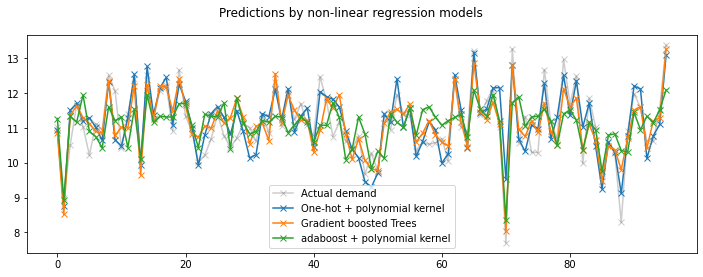

In [69]:
last_hours = slice(-96, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions by non-linear regression models")
ax.plot(
    y.iloc[test_0].values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual demand",
    color="black",
)
ax.plot(
    cyclic_spline_poly_predictions[last_hours],
    "x-",
    label="One-hot + polynomial kernel",
)
ax.plot(
    hgb_poly__predictions[last_hours],
    "x-",
    label="Gradient boosted Trees",
)
ax.plot(
    adabosst_poly_predictions[last_hours],
    "x-",
    label="adaboost + polynomial kernel",
)
_ = ax.legend()

### Make Predictions :

In [57]:
# Train & Test split :

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [58]:
# Fit and Predict : Model 1

naive_linear_pipeline.fit(X_train, y_train)
naive_linear_pipeline.predict(X_test)


array([11.75877944, 11.08791675, 11.91803562, ..., 11.29732911,
       10.40674122, 12.06195843])

In [59]:
# Fit and Predict : Model 2

gbrt_pipeline.fit(X_train, y_train)
gbrt_pipeline.predict(X_test)

array([12.663029  , 11.22908945, 12.11938247, ..., 11.06190409,
        9.51134674, 12.67291079])

In [60]:
target_predicted = gbrt_pipeline.predict(X_test)
predictions = X_test.copy()
predictions['predicted-value'] = target_predicted
predictions['expected-value'] = y_test
predictions['Difference'] = target_predicted - y_test
predictions.head()

,from,to,avg_weeks,std_weeks,flight_year,flight_month,week_day,weekend,holiday,predicted-value,expected-value,Difference
1190,BOS,LGA,8.941176,6.959441,2012,6,0,0,False,12.663029,12.955942,-0.292913
8753,ATL,EWR,11.150000,9.493904,2012,9,0,0,False,11.229089,11.743956,-0.514867
4632,ORD,ATL,10.904762,9.202743,2012,9,3,0,False,12.119382,11.623364,0.496018
200,ORD,IAH,11.863636,8.322634,2012,2,3,0,False,10.927591,11.506174,-0.578583
6698,SFO,ORD,14.923077,11.481892,2011,12,5,1,False,10.517501,9.567137,0.950364


In [61]:
mse_4 = mean_squared_error(y_test, target_predicted)
print("The mean squared error (MSE) on test set: {:.4f}".format(mse_4))

The mean squared error (MSE) on test set: 0.2211


In [62]:
print(
    f"The test accuracy using a {gbrt_pipeline.__class__.__name__} is "
    f"{gbrt_pipeline.score(X_test, y_test):.3f}"
)

The test accuracy using a Pipeline is 0.768


### All in one :

In [82]:
def make_prediction(model, X_train, X_test, y_train, y_test):

    model.fit(X_train, y_train)
    target_predicted  = model.predict(X_test)
    mae = mean_absolute_error(y_test, target_predicted)
    mse = mean_squared_error(y_test, target_predicted)
    rmse = np.sqrt(mse)

    print(f"The model {model.__class__.__name__} scores are :")
    print("-      The mean absolute error (MAE) on test set: {:.4f}".format(mae))
    print("-      The root mean squared error (RMSE) on test set: {:.4f}".format(rmse))
    print(
          f"-      The test accuracy using this model is "
          f"{model.score(X_test, y_test):.3f}"
    )

## All the results :

In [85]:
# Only Numerical data models :

make_prediction(Xbg_model, data_train, data_test, target_train, target_test)
make_prediction(Rf_model, data_train, data_test, target_train, target_test)
make_prediction(best_Rf_model, data_train, data_test, target_train, target_test)

The model GradientBoostingRegressor scores are :
-      The mean absolute error (MAE) on test set: 0.7222
-      The root mean squared error (RMSE) on test set: 0.9373
-      The test accuracy using this model is 0.025
The model RandomForestRegressor scores are :
-      The mean absolute error (MAE) on test set: 0.7216
-      The root mean squared error (RMSE) on test set: 0.9350
-      The test accuracy using this model is 0.029
The model RandomForestRegressor scores are :
-      The mean absolute error (MAE) on test set: 0.7216
-      The root mean squared error (RMSE) on test set: 0.9352
-      The test accuracy using this model is 0.029


In [88]:
# One-hot-Encoding :

print("Ridge")
make_prediction(naive_linear_pipeline, X_train, X_test, y_train, y_test)
print("HGBR")
make_prediction(gbrt_pipeline, X_train, X_test, y_train, y_test)
print("Adaboost")
make_prediction(adaboost_pipeline, X_train, X_test, y_train, y_test)

Ridge
The model Pipeline scores are :
-      The mean absolute error (MAE) on test set: 0.5569
-      The root mean squared error (RMSE) on test set: 0.7171
-      The test accuracy using this model is 0.459
HGBR
The model Pipeline scores are :
-      The mean absolute error (MAE) on test set: 0.3394
-      The root mean squared error (RMSE) on test set: 0.4702
-      The test accuracy using this model is 0.768
Adaboost
The model Pipeline scores are :
-      The mean absolute error (MAE) on test set: 0.6418
-      The root mean squared error (RMSE) on test set: 0.8018
-      The test accuracy using this model is 0.324


In [89]:
# With Sin&Cos Transformation :

print("Ridge :")
make_prediction(cyclic_cossin_linear_pipeline, X_train, X_test, y_train, y_test)
print("HGBR :")
make_prediction(hgb_cossin_pipeline, X_train, X_test, y_train, y_test)
print("Adaboost :")
make_prediction(adabosst_cossin_pipeline, X_train, X_test, y_train, y_test)

Ridge :
The model Pipeline scores are :
-      The mean absolute error (MAE) on test set: 0.5527
-      The root mean squared error (RMSE) on test set: 0.7151
-      The test accuracy using this model is 0.462
HGBR :
The model Pipeline scores are :
-      The mean absolute error (MAE) on test set: 0.3356
-      The root mean squared error (RMSE) on test set: 0.4632
-      The test accuracy using this model is 0.774
Adaboost :
The model Pipeline scores are :
-      The mean absolute error (MAE) on test set: 0.6235
-      The root mean squared error (RMSE) on test set: 0.7854
-      The test accuracy using this model is 0.351


In [100]:
# Spline Transformation :

print("Ridge")
make_prediction(cyclic_spline_linear_pipeline, X_train, X_test, y_train, y_test)
print("HGBR")
make_prediction(hgb_spline_pipeline, X_train, X_test, y_train, y_test)
print("Adaboost")
make_prediction(adabosst_spline_pipeline, X_train, X_test, y_train, y_test)

Ridge
The model Pipeline scores are :
-      The mean absolute error (MAE) on test set: 0.5472
-      The root mean squared error (RMSE) on test set: 0.7033
-      The test accuracy using this model is 0.480
HGBR
The model Pipeline scores are :
-      The mean absolute error (MAE) on test set: 0.3347
-      The root mean squared error (RMSE) on test set: 0.4612
-      The test accuracy using this model is 0.776
Adaboost
The model Pipeline scores are :
-      The mean absolute error (MAE) on test set: 0.6262
-      The root mean squared error (RMSE) on test set: 0.7818
-      The test accuracy using this model is 0.357


In [90]:
# With Kernel :

print("Ridge")
make_prediction(cyclic_spline_poly_pipeline, X_train, X_test, y_train, y_test)
print("HGBR")
make_prediction(hgb_poly_pipeline, X_train, X_test, y_train, y_test)
print("Adaboost")
make_prediction(adabosst_poly_pipeline, X_train, X_test, y_train, y_test)

Ridge
The model Pipeline scores are :
-      The mean absolute error (MAE) on test set: 0.4138
-      The root mean squared error (RMSE) on test set: 0.5532
-      The test accuracy using this model is 0.678
HGBR
The model Pipeline scores are :
-      The mean absolute error (MAE) on test set: 0.4130
-      The root mean squared error (RMSE) on test set: 0.5517
-      The test accuracy using this model is 0.680
Adaboost
The model Pipeline scores are :
-      The mean absolute error (MAE) on test set: 0.6400
-      The root mean squared error (RMSE) on test set: 0.8010
-      The test accuracy using this model is 0.326


## Predict on the test data :

In [ ]:
test_data_pro = date_processing(test_data)

In [ ]:
target_validated_predicted = gbrt_pipeline.predict(test_data_pro)


In [ ]:
target_validated_predicted

array([11.40741215, 10.69515216, 11.69394756, ..., 10.02409972,
       10.27565284, 11.51163554])

In [ ]:
pd.DataFrame(target_validated_predicted).to_csv("submission_gbrt.csv", header=False, index=False)

### All in one :

In [ ]:
def make_submission(test_data, model):

    processed_data = date_processing(test_data)
    target_validated_predicted = model.predict(processed_data)
    file_name = "submission1_" + model.__class__.__name__ + ".csv"
    pd.DataFrame(target_validated_predicted).to_csv(file_name, header=False, index=False)

    print('the submission was successfully done')


In [ ]:
make_submission(test_data, hgb_cossin_pipeline)

the submission was successfully done
